### Preliminary cell to start the notebook

In [41]:
# libraries
import os
import sys
import platform
print(sys.version)

strong_pc = platform.system() == 'Linux'
in_colab = 'google.colab' in sys.modules
if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    #!pip install tensorflow==2.11.0
    #!pip install tensorflow_text==2.11.0
    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules and False:
        print('Installing keras')
        !pip install keras==2.11.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0


if 'DEEPNOTE_ENV' in os.environ:
    os.chdir('/..')
    os.chdir('datasets')
    os.chdir('googledrivedeepnoteintegration')
    os.chdir('Human_Data_Analytics_Project_2023')
    if not 'librosa' in sys.modules:
        print('Installing Librosa')
        !pip install librosa
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.models import load_model

# GPU SETTINGS FOR LINUX and repressing warnings for windows. References for gpu: https://www.tensorflow.org/guide/gpu
show_gpu_activity = False
if sys.platform == 'linux' and not in_colab:
    if show_gpu_activity:
        tf.debugging.set_log_device_placement(True)

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
    # Restrict TensorFlow to only allocate a part of memory on the first GPU
        try:
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=6800)])
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)
else:
    warnings.filterwarnings("ignore", category=UserWarning)

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'Data', 'ESC-10-depth')
samplerate = 22500

3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]
TensorFlow version: 2.12.0
keras version = 2.12.0


In [42]:
main_dir = os.getcwd()
subfolder_path = os.path.join(main_dir, 'Data','balanced')

## Dataset management

Function to delete all the files which are too short or too long, we keep 10 sec files and we will sample half times

In [12]:
from pydub import AudioSegment

# Function to check audio duration
def check_audio_duration(audio_path, target_duration):
    try:
        audio = AudioSegment.from_file(audio_path)
        duration_seconds = len(audio) / 1000  # Convert milliseconds to seconds
        return duration_seconds == target_duration  # Check if duration is exactly equal to the target duration
    except Exception as e:
        return False


# Set the root folder path
root_folder = os.path.join(main_dir, 'Data', 'AudioSet')

# Target duration in seconds    
target_duration = 10
file_count = 0
remode_file = 0

# Iterate through all files in the directory and its subdirectories
for root, dirs, files in os.walk(root_folder):
    for file in files:
        # Check if the file has an audio file extension (e.g., .mp3, .wav, .ogg, etc.)
        if file.endswith(('.mp3', '.wav', '.ogg', '.flac', '.aac')):
            audio_path = os.path.join(root, file)
            file_count += 1
            if not check_audio_duration(audio_path, target_duration):
                # delete the file
                os.remove(audio_path)
                remode_file += 1


In [13]:
print(f'Number of files: {file_count}')
print(f'Number of removed files: {remode_file}') # around 3000 files removed


Number of files: 49625
Number of removed files: 2885


Renaming the folders from name = label, to name = number in order to use US_training (modified into AS_training)

In [17]:
#renaming the folders

import os
# Set the root folder path
path = os.path.join(main_dir, 'Data', 'AudioSet')
count = 1
for folder_name in sorted(os.listdir(path)):
    if os.path.isdir(os.path.join(path, folder_name)):
        # Create a new name with a three-digit number
        new_name = f"{count:03d}"
        
        # Construct the full paths to the old and new folders
        old_folder_path = os.path.join(path, folder_name)
        new_folder_path = os.path.join(path, new_name)
        
        # Rename the subfolder
        os.rename(old_folder_path, new_folder_path)
        
        count += 1

Converting wav files if needed (skipped)

In [38]:
# If we want to convert the audio files to OGG format, we can use the following code:
# But we do not do it because it takes too long, instead we use the original files modifying the function create_dataset

# Set the root folder path
root_folder = os.path.join(main_dir, 'Data', 'AudioSet')

# Iterate through all files in the directory and its subdirectories
for root, dirs, files in os.walk(root_folder):
    for file in files:
        # Check if the file has a WAV file extension
        if file.endswith('.wav'):
            # Construct the full path to the file
            file_path = os.path.join(root, file)
            
            # Specify the output OGG file path
            ogg_file_path = file_path.replace('.wav', '.ogg')
            
            # Use VLC to convert WAV to OGG format with a timeout of 60 seconds
            vlc_command = [
                '/Applications/VLC.app/Contents/MacOS/VLC',
                '--intf', 'dummy',  # Use the dummy interface (no GUI)
                '--no-sout-video',  # Disable video output
                '--sout', f'#transcode{{acodec=vorb,ab=128,channels=2,samplerate=44100}}:std{{access=file,mux=ogg,dst="{ogg_file_path}"}}',
                file_path  # Input WAV file
            ]
            
            # Run the VLC command with a timeout
            try: 
                completed_process = subprocess.run(vlc_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, timeout=0.5)
            except subprocess.TimeoutExpired:
                #check if there exists a file with the same name and its weight is not 0
                if os.path.exists(ogg_file_path) and os.path.getsize(ogg_file_path) > 0:
                    #print(f'Converted "{file_path}" to "{ogg_file_path}"')
                    continue
                else:
                    try:
                        completed_process = subprocess.run(vlc_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, timeout=1)
                    except subprocess.TimeoutExpired:
                        if os.path.exists(ogg_file_path) and os.path.getsize(ogg_file_path) > 0:
                            #print(f'Converted "{file_path}" to "{ogg_file_path}"')
                            continue
                        else: 
                            try:
                                completed_process = subprocess.run(vlc_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, timeout=10)
                            except subprocess.TimeoutExpired:
                                if os.path.exists(ogg_file_path) and os.path.getsize(ogg_file_path) > 0:
                                    #print(f'Converted "{file_path}" to "{ogg_file_path}"')
                                    continue
                                else:
                                    print(f'Failed to convert "{file_path}" to "{ogg_file_path}"')
                                    continue
                    continue

## Autoencoder training (using 3.3)

In [43]:
preprocessing = 'STFT'
AE_name = 'AE_Conv_prep_flatten_'+preprocessing + '_AudioSet'

In [44]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [ AE_name+'_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created AE_Conv_prep_flatten_STFT_AudioSet_count.txt with content '0' in folder Saved_Models


In [45]:
# Now, you have a TensorFlow dataset with spectrograms and labels.
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa
from scipy.interpolate import RegularGridInterpolator

In [50]:
def create_AS_dataset(folder,val_split = 0.25): #folder = '001'
    # Create an empty list to store spectrograms and labels
    spectrograms = []

    # Define the target shape for spectrograms
    target_shape = (64, 128)

    list_audio_files = os.listdir(os.path.join(main_dir, 'Data', 'AudioSet', folder))

    for audio_file in list_audio_files:
        audio_path = os.path.join(main_dir, 'Data', 'AudioSet', folder , audio_file)
        audio, sr = librosa.load(audio_path, sr=22050, mono=True)
        stft = librosa.stft(audio)
        #stft = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

        # from create dataset function
        #stft_librosa = librosa.stft(audio, hop_length=hop_length, win_length=nperseg, n_fft=n_fft)
        #r = librosa.amplitude_to_db(np.abs(stft_librosa), ref=np.max)

        # Create a grid of indices for the original spectrogram
        x = np.linspace(0, stft.shape[1] - 1, stft.shape[1])
        y = np.linspace(0, stft.shape[0] - 1, stft.shape[0])

        # Create the interpolator function
        interpolator = RegularGridInterpolator((y, x), stft)

        # Create a grid of indices for the target shape
        target_x = np.linspace(0, stft.shape[1] - 1, target_shape[1])
        target_y = np.linspace(0, stft.shape[0] - 1, target_shape[0])

        # Create a meshgrid of target indices
        target_x, target_y = np.meshgrid(target_x, target_y)

        # Stack the indices as a 2D array
        target_indices = np.vstack((target_y.ravel(), target_x.ravel())).T

        # Interpolate to get the resized STFT
        stft = interpolator(target_indices).reshape(target_shape)

        # Change dim to (64, 128, 1)
        stft = stft.reshape(64, 128, 1)

        # Append the spectrogram and label to the lists (modify this part to include labels)
        spectrograms.append(stft)

    # Convert the lists to numpy arrays
    spectrograms = np.array(spectrograms)

    # for entry of each spectrogram take the norm since it is a complex number
    spectrograms = np.abs(spectrograms)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((spectrograms,spectrograms))

    # Shuffle and batch the dataset (modify batch size and buffer size as needed)
    batch_size = 32
    buffer_size = 1000

    #divide into train, val, test
    dataset = dataset.shuffle(buffer_size)
    n = len(dataset)
    n_val = int(n*val_split)
    n_test = int(n*val_split)
    n_train = n - n_val - n_test
    train = dataset.take(n_train)
    val = dataset.skip(n_train).take(n_val)
    test = dataset.skip(n_train+n_val).take(n_test)
    
    #batch the dataset
    train = train.batch(batch_size)
    val = val.batch(batch_size)
    test = test.batch(batch_size)

    INPUT_DIM = spectrograms[0].shape

    return train, val, test, INPUT_DIM

In [51]:
train, val, test, INPUT_DIM = create_AS_dataset('001')

In [52]:
def num_3(i):
    if i<10:
        return '00'+str(i)
    elif (i<100) and (i>=10):
        return '0'+str(i)
    else:
        return str(i)

In [53]:
#General function to build an autoencoder
#CONVOLUTIONAL AUTOENCODER WITH VECTORIAL CODE
code_size = 32
n_layers = 2
n_units = 32

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_size = code_size,
                      activation = 'tanh',
                      padding = 'valid',
                      n_layers = n_layers, #max number of layers is 3
                      n_units = n_units,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      AE_name = AE_name
 ):
    lr = learning_rate
    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))
    for i in range(n_layers):
        encoder.add(layers.Conv2D(n_units * (i+1), kernel_size,strides = strides, activation = activation, padding=padding))
        encoder.add(layers.MaxPool2D(max_pooling, padding='same'))
        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    # flatten layer to get the code
    my_shape = encoder.layers[-1].output_shape
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size,activation = activation, activity_regularizer=keras.regularizers.l1(regularizer)))

    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(code_size))
    decoder.add(layers.Dense(np.prod(my_shape[1:]), activation=activation))
    decoder.add(layers.Reshape(my_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):
        filters = n_units * (n_layers-i) if i<n_layers-1 else 1
        decoder.add(layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, padding=padding))
        decoder.add(layers.UpSampling2D(size=max_pooling))
        if batch_norm:
            decoder.add(layers.BatchNormalization())

    #final reshape
    decoder.add(tf.keras.layers.Resizing(height = INPUT_DIM[0], width = INPUT_DIM[1], interpolation="bilinear", crop_to_aspect_ratio=False))

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = AE_name)

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder

In [54]:
def AS_training(AE_name,
                autoencoder,
                n_folders,
                epochs = 50,
                preprocessing = None,
                patience=10,
                verbose = 0,
                ndim = 3,
                metrics = ['mse'],
                ):

    #paramteres for the fit and callbacks
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                mode='max',
                                                verbose=verbose,
                                                restore_best_weights=True,
                                                patience=patience)]

    #read the file txt to know the folder to start 
    with open(os.path.join(main_dir,'Saved_Models',AE_name+'_count.txt'), 'r') as file:
        last_folder = int(file.read())
        print(f'Last folder trained: {last_folder}')

    if n_folders < last_folder:
        print('The number of folders is smaller than the last folder trained!')
        n_folders = last_folder
    
    for i in range(last_folder+1,n_folders+1):

        #load the model if i > 1
        if i>1:
            autoencoder = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))

        #create the dataset

        train, val, test, INPUT_DIM =  create_AS_dataset( folder = num_3(i), val_split = 0.25)
        
        #fit the autoencoder
        history = autoencoder.fit(train, validation_data= val, epochs=epochs, callbacks = callbacks, verbose=0)

        #save the model
        autoencoder.save(os.path.join(main_dir,'Saved_Models',AE_name), save_format  ='keras')

        #show the best epoch
        val_acc_per_epoch = history.history['val_'+metrics[0]]
        best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
        if verbose > 0:
            print('Best epoch: %d' % (best_epoch,))
        
        if verbose > 1:
            #plot the history of the training
            plot_history(history)

            #evaluate the model on the test set
            scores = autoencoder.evaluate(test, return_dict=False)
            display(scores)

        #update the number on the txt file overwritting the previoAS one
        with open(os.path.join(main_dir,'Saved_Models',AE_name+'_count.txt'), 'w') as file:
            file.write(str(i))

    # retrive the size of the model
    print(f"This model has a size of {get_model_size(autoencoder)} MB")
     
    return autoencoder

In [55]:
best_params = {
    'n_layers':1,
    'n_units':16,
    'kernel_size':3,
    'strides':3,
    'max_pooling':3,
    'regularizer':0.0001,
    'padding':'valid',
    'code_size':32,
    'activation':'elu',
    'drop_out':0.0,
    'batch_norm':False,
    'learning_rate':0.005,
}

# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

epochs = 50 #50
n_folders = 528 #528
verbose = 0

AS_training(AE_name = AE_name, autoencoder = autoencoder, epochs = epochs , n_folders = n_folders , preprocessing = preprocessing, ndim=3, verbose=verbose)

Model built with 102257 trainable params
Model: "AE_Conv_prep_flatten_STFT_AudioSet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________
Last folder trained: 0


2023-09-10 19:37:35.802234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:36.112070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:36.465897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape 

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:37.969054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:38.205977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:38.514005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:40.629364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:40.857359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:41.334587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:43.110646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:43.323275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:43.727529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:45.452440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:45.657696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:46.054224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:47.458869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:47.686840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:48.014895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:49.611261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:49.821105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:50.142326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:52.708517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [105,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:52.925875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [105,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:54.245759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:56.118964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:56.359087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:56.699223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:37:58.219676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:37:58.453878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:37:58.879532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:00.384939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:00.591985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:00.888417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:02.351551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:02.555991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:02.852535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:04.612221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:04.844217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:05.161792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:07.468334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:07.684116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:08.173209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:09.807489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:10.011878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:10.603720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:20.135413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [637,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:20.441960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [637,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:22.439078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:24.002526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:24.208733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:24.746889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:26.240159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:26.445041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:26.767651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:28.197668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:28.398850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:28.738398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:30.866806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:31.070532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:31.595061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:32.815054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:33.017816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:33.425474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:34.958524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:35.162675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:35.543106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:37.151945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:37.359924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:37.756790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:39.289319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:39.494251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:39.791929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:41.211312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:41.417410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:41.740045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:43.859582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:44.065115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:44.420423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:45.871380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:46.075426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:46.405072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:48.001350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:48.213101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:48.521909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:50.510706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [84,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:50.510899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [84,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:50.752678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:52.917050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:53.121437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:53.614377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:55.114824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:55.327304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:55.634709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:57.821175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:38:58.024441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:38:58.380996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:38:59.907281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:00.113447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:00.390246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:01.916203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:02.120019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:02.437346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:03.874554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:04.077916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:04.446200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:06.001100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:06.205455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:06.577623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:08.021731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:08.225366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:08.531286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:10.594713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:10.805279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:11.113340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:12.595360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:12.808646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:13.257022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:14.621369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:14.823010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:15.143942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:18.219949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [161,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:18.444861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [161,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:19.271219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:20.804045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:21.009070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:21.309403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:23.724665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [118,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:23.936749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [118,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:25.002185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:26.487293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:26.705277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:26.983429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:28.244153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [40,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:28.445182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [40,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:28.811457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:30.311885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:30.514529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:30.850640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:32.446899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:32.685177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:33.093295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:34.661904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:34.872935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:35.156740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:39.758970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [227,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:39.990046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [227,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:41.192073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:42.657570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:42.863825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:43.385848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:44.876908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:45.080763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:45.405389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:46.973367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:47.177406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:47.500627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:49.017582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:49.222854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:49.589056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:50.978475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:39:51.180852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:51.603239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:54.703550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [111,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:54.932983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [111,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:39:55.488871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:39:59.974047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [220,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:00.281394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [220,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:01.013876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:02.601018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:02.875097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:03.173555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-10 19:40:04.786881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:05.088148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-10 19:40:05.439203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

### Show the reconstruction capabilities of the model

Model: "AE_Conv_prep_flatten_STFT_AudioSet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 13ms/step


2023-09-10 19:16:00.729909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100]
	 [[{{node Placeholder/_4}}]]
2023-09-10 19:16:00.730249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 10ms/step


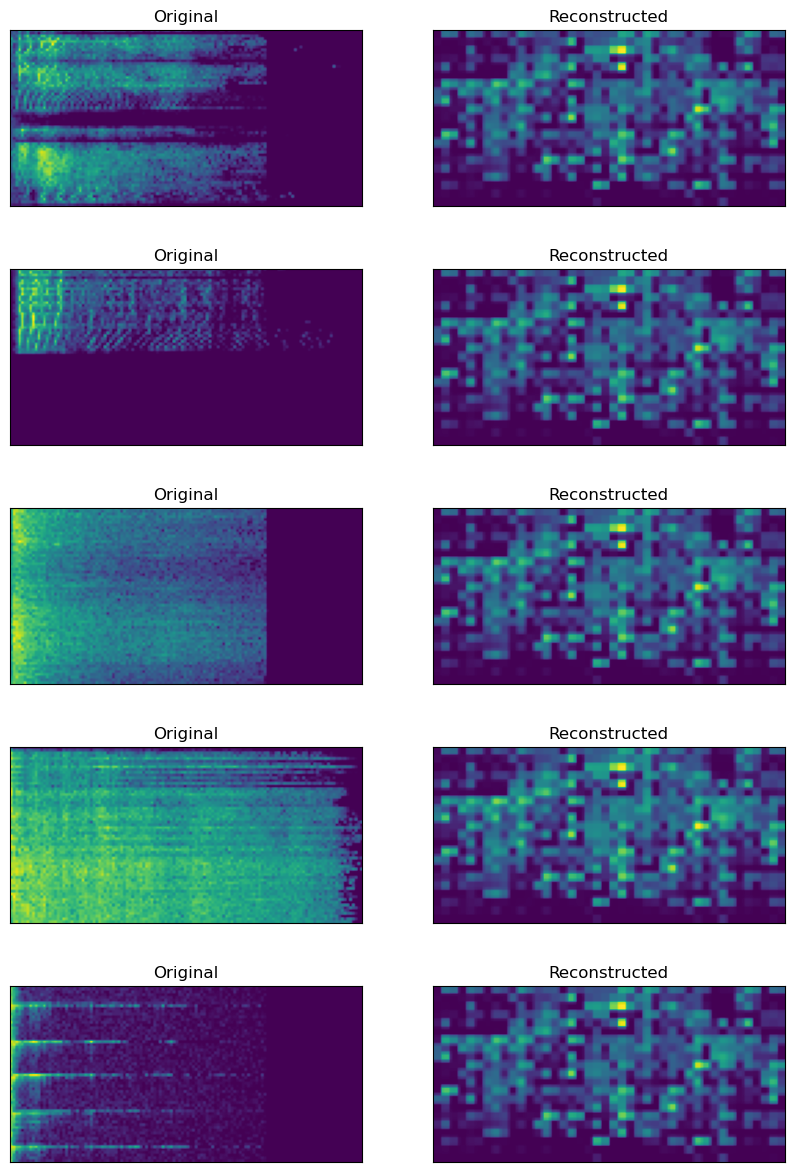

In [ ]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)

Now let's see the reconstruction capability on the test set of ESC-10

Found 400 files belonging to 10 classes.


Using 300 files for training.
Using 100 files for validation.


2023-09-10 19:09:06.946096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-09-10 19:09:06.946265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]


Model: "AE_Conv_prep_flatten_STFT_AudioSet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________


2023-09-10 19:09:08.775185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-09-10 19:09:08.775496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 11ms/step


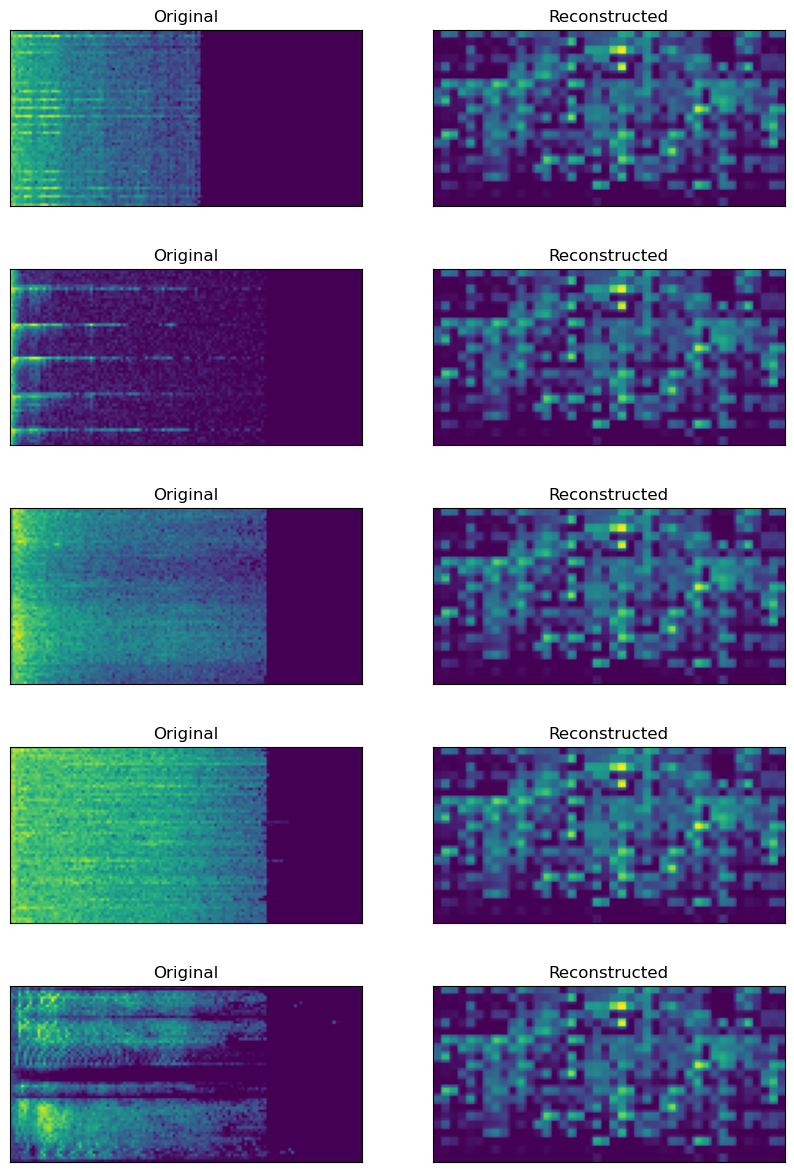

In [ ]:
train, val, test, label_names = create_dataset( ESC10_path,
                                                verbose = 0,
                                                batch_size = 30,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT" or "MFCC"
                                                show_example_batch = False,
                                                ndim=3,
                                                resize = True,
                                                new_width = 64,
                                                new_height= 128)
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()
# show n original and reconstructed images
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)